In [ ]:
# !pip install imblearn
# !pip install missingpy
# !pip install auto-sklearn
!pip install mlxtend 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd 
import numpy as np 
import sys

## runtwice! import error during first run
# from autosklearn.estimators import AutoSklearnClassifier
# from autosklearn.metrics import balanced_accuracy, precision, recall, f1

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder 

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

import sklearn 
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
import xgboost
import six
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import EnsembleVoteClassifier

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from imblearn.over_sampling import SMOTE, ADASYN
pd.options.mode.chained_assignment = None  # default='warn'
nn=20

In [ ]:
# "https://drive.google.com/file/d/1TtJWQsnTuoRbsTzHlDq6xXxKBqVX6bzl/view?usp=share_link"

!gdown 1TtJWQsnTuoRbsTzHlDq6xXxKBqVX6bzl
df_raw = pd.read_csv('data.csv')

Downloading...
From: https://drive.google.com/uc?id=1TtJWQsnTuoRbsTzHlDq6xXxKBqVX6bzl
To: /content/data.csv
100% 23.1M/23.1M [00:00<00:00, 191MB/s]


In [ ]:
# Assuming solution attibutes can't be used to predict incident as it's a historical data based on priority of the ticket

ticket_attributes = ['ID', 'ID_status', 'active', 'count_reassign',
       'count_opening', 'count_updated', 'ID_caller', 'opened_by',
       'opened_time', 'Created_by', 'created_at', 'updated_by', 'updated_at',
       'type_contact', 'location', 'category_ID', 'user_symptom']

solution_attributes = ['Support_group', 'support_incharge', 'Doc_knowledge',
       'confirmation_check', 'impact', 'notify', 'problem_ID',
       'change_request']

In [ ]:
df_ticket = df_raw[ticket_attributes]
df_solution = df_raw[solution_attributes]

In [ ]:
# convert to date time format Time data 
df_ticket['created_at'] = pd.to_datetime(df_ticket['created_at'],errors='coerce')
df_ticket['opened_time'] = pd.to_datetime(df_ticket['opened_time'],errors='coerce')
df_ticket['updated_at'] = pd.to_datetime(df_ticket['updated_at'],errors='coerce')

In [ ]:
#EDA
'''
# find anomalies 
df_raw['impact'].value_counts()
for col in df_ticket:
  print(df_ticket[col].value_counts(normalize=True))
print(df_ticket.nunique())

df_solution['Support_group'].value_counts(normalize=True)
df_ticket['category_ID'].value_counts(normalize=True)
df_raw['impact'].value_counts(normalize=True).reset_index()

impact_vc = df_raw['impact'].value_counts().reset_index()
data = impact_vc['impact'].tolist()
keys = impact_vc['index'].tolist()
  
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.tight_layout()
plt.title("Impact % value count")
# displaying chart
plt.show()

print("Incident Medium Doc_knowledge\n",df_raw[df_raw['impact']=='2 - Medium']['Doc_knowledge'].value_counts(normalize=True))
print("Incident Low Doc_knowledge\n",df_raw[df_raw['impact']=='3 - Low']['Doc_knowledge'].value_counts(normalize=True))
print("Incident High Doc_knowledge\n",df_raw[df_raw['impact']=='1 - High']['Doc_knowledge'].value_counts(normalize=True))

print("Incident Medium count_opening\n",df_raw[df_raw['impact']=='2 - Medium']['count_opening'].value_counts(normalize=True))
print("Incident Low count_opening\n",df_raw[df_raw['impact']=='3 - Low']['count_opening'].value_counts(normalize=True))
print("Incident High count_opening\n",df_raw[df_raw['impact']=='1 - High']['count_opening'].value_counts(normalize=True))
'''

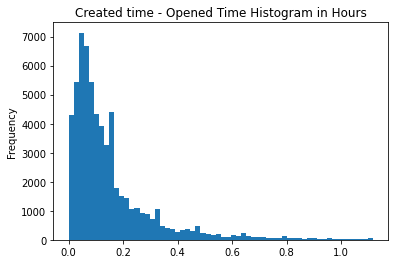

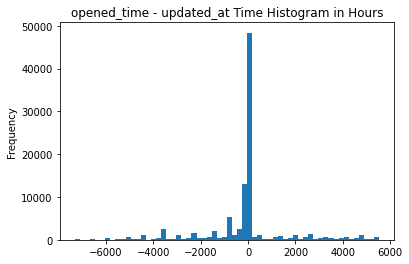

In [ ]:
# EDA
'''
pd_series = (df_ticket['created_at']-df_ticket['opened_time']).dt.total_seconds()/3600
pd_series_adjusted = pd_series[pd_series.between(pd_series.quantile(.001), pd_series.quantile(.99))] 
pd_series_adjusted.plot.hist(bins=60)
plt.title("Created time - Opened Time Histogram in Hours")
plt.show()

pd_series = (df_ticket['opened_time']- df_ticket['updated_at']).dt.total_seconds()/3600
pd_series_adjusted = pd_series[pd_series.between(pd_series.quantile(.001), pd_series.quantile(.99))] 
pd_series_adjusted.plot.hist(bins=60)

plt.title("opened_time - updated_at Time Histogram in Hours")
plt.show()

# print null time columns
# print(pd.isna(df_ticket['created_at']).sum())
# print(pd.isna(df_ticket['opened_time']).sum())
# print(pd.isna(df_ticket['updated_at']).sum())

'''

In [ ]:
# Feature engineering

# Days of the Week [Sun, Mon, ...]
df_ticket['created_at_weekday'] = df_ticket['created_at'].dt.day_name()
df_ticket['opened_time_weekday'] = df_ticket['opened_time'].dt.day_name()
df_ticket['updated_at_weekday'] = df_ticket['updated_at'].dt.day_name()


# working hours, late working hours - based on Location  
# Since locations are encoded can't convert to local time. 

# Days of the Week [Sun, Mon, ...]
df_ticket['created_at_weekday'] = df_ticket['created_at'].dt.day_name()
df_ticket['opened_time_weekday'] = df_ticket['opened_time'].dt.day_name()
df_ticket['updated_at_weekday'] = df_ticket['updated_at'].dt.day_name()
# df_ticket['created_at_weekday'] = df_ticket['created_at_weekday'].fillna('unknown')

#Time of the day
df_ticket['created_at_hour'] = df_ticket['created_at'].dt.hour
df_ticket['opened_time_hour'] = df_ticket['opened_time'].dt.hour
df_ticket['updated_at_hour'] = df_ticket['updated_at'].dt.hour
# df_ticket['created_at_hour'] = df_ticket['created_at_hour'].fillna(999)

# Groupby ID & category_ID	for opened_time_hour mean
df_ticket_ID_hour = df_ticket.groupby('ID')['opened_time_hour'].agg(['mean']) \
            .rename(columns={'mean':'ID'+'_'+'opened_time_hour'+'_mean'}).reset_index()
df_ticket = df_ticket.merge(df_ticket_ID_hour, how='left', on= 'ID')

df_ticket_category_ID_hour = df_ticket.groupby('category_ID')['opened_time_hour'].agg(['mean']) \
            .rename(columns={'mean':'category_ID'+'_'+'opened_time_hour'+'_mean'}).reset_index()
df_ticket = df_ticket.merge(df_ticket_category_ID_hour, how='left', on= 'category_ID')

In [ ]:
# ? is used instead of null
# replace '?' by null

df_ticket = df_ticket.replace('?', np.nan)

df_ticket.loc[df_ticket['ID_status']=='-100', 'ID_status'] = np.nan


In [ ]:
# drop raw time columns 
df_ticket = df_ticket.drop(columns=['created_at','opened_time','updated_at'])


In [ ]:
# Since high priority is what we need to predict
# assume low priority is not neccesary to be predicted include it with Medium priority 

# Label Encode Target - create binary (Low+medium) & High priority 
df_solution['impact'] = df_solution['impact'].map({'1 - High':1, '2 - Medium':2,'3 - Low':2 })

In [ ]:
# 5% for validation/Inference 
X, X_val, y, y_val = train_test_split(df_ticket, df_solution['impact'], test_size=0.05, random_state=42)


In [ ]:
# what dtype format are present for numeric for independent variables
numberical_dtype_list = ['int64','float64']

# get cat & numeric column names
cat_columns = X.select_dtypes(exclude=numberical_dtype_list).columns.tolist()
num_columns = X.select_dtypes(include=numberical_dtype_list).columns.tolist()

print("CATEGORICAL COLUMNS:", cat_columns)

print("NUMERICAL COLUMNS ",num_columns)

CATEGORICAL COLUMNS: ['ID', 'ID_status', 'active', 'ID_caller', 'opened_by', 'Created_by', 'updated_by', 'type_contact', 'location', 'category_ID', 'user_symptom', 'created_at_weekday', 'opened_time_weekday', 'updated_at_weekday']
NUMERICAL COLUMNS  ['count_reassign', 'count_opening', 'count_updated', 'created_at_hour', 'opened_time_hour', 'updated_at_hour', 'ID_opened_time_hour_mean', 'category_ID_opened_time_hour_mean']


In [ ]:
def clip_cat_labels(df: pd.DataFrame, cat_columns: list, label_count=3) -> pd.DataFrame:
    '''
    Description: Clip categorical columns values (to Nan) that has value count less than a threshold (label_count)
    args: DataFrame, cat_columns [list], label_count to be clipped
    output: DataFrame with labels clipped
    '''
    df_cat_clipped = df.copy()
    for col in cat_columns:
        value_count_df = df[col].value_counts().reset_index()
        cat_values_with_low_count = value_count_df[value_count_df[col]<=label_count]['index'].tolist()
        cat_clipped = df[col].mask(df[col].isin(cat_values_with_low_count))
        df_cat_clipped[col] = cat_clipped
    return df_cat_clipped

In [ ]:
#Clip redudant label categories which won't help in learning 
X_clipped = clip_cat_labels(X, cat_columns, label_count = 3)

# fillna with Custom "Unknown" values 
X_clipped[cat_columns] = X_clipped[cat_columns].fillna('Unknown')
X_clipped['created_at_hour'] = X_clipped['created_at_hour'].fillna(X_clipped['created_at_hour'].mode()[0])
X_clipped.isna().sum()

ID                                   0
ID_status                            0
active                               0
count_reassign                       0
count_opening                        0
count_updated                        0
ID_caller                            0
opened_by                            0
Created_by                           0
updated_by                           0
type_contact                         0
location                             0
category_ID                          0
user_symptom                         0
created_at_weekday                   0
opened_time_weekday                  0
updated_at_weekday                   0
created_at_hour                      0
opened_time_hour                     0
updated_at_hour                      0
ID_opened_time_hour_mean             0
category_ID_opened_time_hour_mean    0
dtype: int64

In [ ]:
#Label Encoding 
# create dict to save encoder objects for inference
encoders = dict()
# add "Unknown" row to last row to handle unknown labels at inference
dummy_unknown = pd.DataFrame(columns=list(X_clipped.columns))
dummy_unknown.loc['ayz', cat_columns] = 'Unknown'
dummy_unknown.loc['ayz', num_columns] = 0
dummy_unknown = dummy_unknown.astype(X_clipped.dtypes.to_dict())
X_clipped = X_clipped.append(dummy_unknown)

In [ ]:
# Label encode with nan and save encoder
encoders = dict()
for col_name in cat_columns:
    series = X_clipped[col_name]
    label_encoder = LabelEncoder()
    X_clipped[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
                            index=series[series.notnull()].index)
    encoders[col_name] = label_encoder

# Remove dummy "Unknown" row
X_clipped = X_clipped[:-1]
X_encoded = X_clipped.copy()

In [ ]:
# Tried KNN Imputer, missforest, iterative imputer, SimpleImputer(mode) doesn't improve metrics

# impute using KNN imputer
# https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
# imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# imputer_object = imputer.fit(X_encoded.to_numpy())
# X_encoded[:] = imputer_object.transform(X_encoded.to_numpy())

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [ ]:
# 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42)

In [ ]:
# XGBoost Model 
%%time
X_train_xgb, y_train_xgb = X_train.copy(), y_train.copy()
X_test_xgb, y_test_xgb = X_test.copy(), y_test.copy()

# Used Sklearn feature selection tool to find unimportant feature list (Code at the end of notebook)
unimportant_features = ['updated_at_weekday','ID_caller','type_contact','count_opening','updated_at_hour','count_reassign',
                        'created_at_hour','opened_time_weekday','Created_by','created_at_weekday','location',
                        'count_updated','updated_by','opened_by','ID_status','user_symptom','active']

# drop unimportant features
X_train_xgb = X_train_xgb.drop(columns = unimportant_features)
X_test_xgb = X_test_xgb.drop(columns=unimportant_features)

# get class weights to mitigate imbalance 
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_xgb)

# define model
model_xgb = XGBClassifier(max_depth=16, n_estimators= 100, learning_rate=0.2,
                          min_child_weight=1, gamma=0.5) 

model_xgb.fit(X_train_xgb, y_train_xgb, sample_weight=classes_weights)

# Metrics
predictions_xgb = model_xgb.predict(X_test_xgb)

print("_"*nn, "XGBoost Test Metric Report", "_"*nn)
print(confusion_matrix(y_test_xgb, predictions_xgb))
print(sklearn.metrics.classification_report(y_test_xgb, predictions_xgb, digits=2))

____________________ XGBoost Test Metric Report ____________________
[[  440    29]
 [  641 17738]]
              precision    recall  f1-score   support

           1       0.41      0.94      0.57       469
           2       1.00      0.97      0.98     18379

    accuracy                           0.96     18848
   macro avg       0.70      0.95      0.77     18848
weighted avg       0.98      0.96      0.97     18848

CPU times: user 12.4 s, sys: 25.1 ms, total: 12.4 s
Wall time: 14.1 s


In [ ]:
# Random Forest
%%time
# SMOTE and ADASYN for oversampling doesn't improve metrics using weights instead  
# oversample = ADASYN(random_state=42)
# X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
# print(y.value_counts())

# Model & parameter are found using autoSKlearn tool
model_rf = RandomForestClassifier(max_features=4, n_estimators=512, n_jobs=1,
                         random_state=1, warm_start=True)
model_rf.fit(X_train, y_train, sample_weight=classes_weights)

# Metrics
predictions_rf = model_rf.predict(X_test)

print("_"*nn, "RANDOM FOREST Test Metric Report", "_"*nn)
print(confusion_matrix(y_test, predictions_rf))
print(sklearn.metrics.classification_report(y_test, predictions_rf, digits=2))


____________________ RANDOM FOREST Test Metric Report ____________________
[[  242   227]
 [   19 18360]]
              precision    recall  f1-score   support

           1       0.93      0.52      0.66       469
           2       0.99      1.00      0.99     18379

    accuracy                           0.99     18848
   macro avg       0.96      0.76      0.83     18848
weighted avg       0.99      0.99      0.99     18848

CPU times: user 59.9 s, sys: 91.3 ms, total: 1min
Wall time: 1min 5s


In [ ]:
#Ensemble  XGBoost and RandomForest models using soft(predict_proba) voting
%%time

eclf = EnsembleVoteClassifier(clfs=[model_rf, model_xgb], weights=[2, 1], voting='soft')
eclf.fit(X_train_xgb, y_train)
predictions = eclf.predict(X_test_xgb)

print("_"*nn, "ENSEMBLE(RF+XGB) Test Metric Report", "_"*nn)
print(confusion_matrix(y_test, predictions))
print(sklearn.metrics.classification_report(y_test, predictions, digits=2))

____________________ ENSEMBLE(RF+XGB) Test Metric Report ____________________
[[  353   116]
 [   74 18305]]
              precision    recall  f1-score   support

           1       0.83      0.75      0.79       469
           2       0.99      1.00      0.99     18379

    accuracy                           0.99     18848
   macro avg       0.91      0.87      0.89     18848
weighted avg       0.99      0.99      0.99     18848

CPU times: user 1min 14s, sys: 144 ms, total: 1min 14s
Wall time: 1min 24s


In [ ]:
%%time
from typing import Dict
#_________Inference using 5% valiation data________#
def inference_label_transform(df: pd.DataFrame, encoders: Dict) -> pd.DataFrame:
  """
  Label encode inference DF using saved Training encoder dict, where the new values get assigned to Unknown class
  args: unlabeled DataFrame, encoders Dict from Training
  return: Label Encoded DataFrame
  """
  column_names = list(encoders.keys())
  df_encoded = df.copy()
  for col in column_names:
    data_list = df[col].fillna('Unknown')
    label_encoder = encoders[col]
    new_data_list = list(data_list)
    unique_items = np.unique(data_list)
    for unique_item in unique_items:
        if unique_item not in label_encoder.classes_:
            new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
    df_encoded[col] = label_encoder.transform(new_data_list)
  return df_encoded

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 24.1 µs


In [ ]:
#____________Inference/val Preprocesssing ____________#
# Inference from saved imputer object and label encoded dict 
## convert types
X_val = X_val.astype(df_ticket.dtypes.to_dict())

## Imputing
X_val_inf = X_val.copy()

# fillna with Custom "Unknown" values 
X_val_inf[cat_columns] = X_val_inf[cat_columns].fillna('Unknown')
X_val_inf['created_at_hour'] = X_val_inf['created_at_hour'].fillna(X_val_inf['created_at_hour'].mode()[0])
print(X_val_inf.isna().sum())

## Label encoding
X_val_encoded = inference_label_transform(X_val_inf, encoders)

ID                                   0
ID_status                            0
active                               0
count_reassign                       0
count_opening                        0
count_updated                        0
ID_caller                            0
opened_by                            0
Created_by                           0
updated_by                           0
type_contact                         0
location                             0
category_ID                          0
user_symptom                         0
created_at_weekday                   0
opened_time_weekday                  0
updated_at_weekday                   0
created_at_hour                      0
opened_time_hour                     0
updated_at_hour                      0
ID_opened_time_hour_mean             0
category_ID_opened_time_hour_mean    0
dtype: int64


In [ ]:
%%time
## RF Inference 
y_val_pred_rf = model_rf.predict(X_val_encoded)

## XGB Inference
y_val_pred_xgb = model_xgb.predict(X_val_encoded.drop(columns=unimportant_features))

## Ensemble model
y_val_pred_xgb_eclf = eclf.predict(X_val_encoded.drop(columns=unimportant_features))


#___________________Inference/Val Metrics_________________#
## RF Metrics report

print("_"*nn,"Validation/Inference","_"*nn)
print("_"*nn,"RF Metrics report","_"*nn)
print(confusion_matrix(y_val, y_val_pred_rf))
print(sklearn.metrics.classification_report(y_val, y_val_pred_rf, digits=2))

## XGB Metrics report
print("_"*nn, "XGB Metrics report", "_"*nn)
print(confusion_matrix(y_val, y_val_pred_xgb))
print(sklearn.metrics.classification_report(y_val, y_val_pred_xgb, digits=2))

## Ensemble Metrics report
print("_"*nn, "Ensemble (RF+XGB) Metrics report", "_"*nn)
print(confusion_matrix(y_val, y_val_pred_xgb_eclf))
print(sklearn.metrics.classification_report(y_val, y_val_pred_xgb_eclf, digits=2))


____________________ Validation/Inference ____________________
____________________ RF Metrics report ____________________
[[  72   61]
 [   5 4822]]
              precision    recall  f1-score   support

           1       0.94      0.54      0.69       133
           2       0.99      1.00      0.99      4827

    accuracy                           0.99      4960
   macro avg       0.96      0.77      0.84      4960
weighted avg       0.99      0.99      0.98      4960

____________________ XGB Metrics report ____________________
[[ 119   14]
 [ 216 4611]]
              precision    recall  f1-score   support

           1       0.36      0.89      0.51       133
           2       1.00      0.96      0.98      4827

    accuracy                           0.95      4960
   macro avg       0.68      0.92      0.74      4960
weighted avg       0.98      0.95      0.96      4960

____________________ Ensemble (RF+XGB) Metrics report ____________________
[[  95   38]
 [  17 4810]]
      

## **Below Codes are used for,** 
* Model selection
* Feature selection
* Hyperparameter tuning 

In [ ]:
#Fine tune ensamble for softweight between RF & XGB 
# Precision Vs Recall ---> Bussiness needs to be considered
%%time
for class_weight in np.arange(1,5,1):
  print("___________Class weight = ", class_weight," ________________")
  eclf = EnsembleVoteClassifier(clfs=[model_rf, model_xgb], weights=[class_weight, 1], voting='soft')
  eclf.fit(X_train_xgb, y_train)
  predictions = eclf.predict(X_test_xgb)
  print(confusion_matrix(y_test, predictions))
  print(sklearn.metrics.classification_report(y_test, predictions, digits=2))

  y_val_pred_xgb_eclf = eclf.predict(X_val_encoded.drop(columns=unimportant_features))
  ## Ensemble Metrics report
  print("Ensemble (RF+XGB) Metrics report")
  print(confusion_matrix(y_val, y_val_pred_xgb_eclf))
  print(sklearn.metrics.classification_report(y_val, y_val_pred_xgb_eclf, digits=2))


___________Class weight =  1  ________________
[[  349   120]
 [   74 18305]]
              precision    recall  f1-score   support

           1       0.83      0.74      0.78       469
           2       0.99      1.00      0.99     18379

    accuracy                           0.99     18848
   macro avg       0.91      0.87      0.89     18848
weighted avg       0.99      0.99      0.99     18848

____________________ Ensemble (RF+XGB) Metrics report ____________________
[[ 119   14]
 [ 216 4611]]
              precision    recall  f1-score   support

           1       0.36      0.89      0.51       133
           2       1.00      0.96      0.98      4827

    accuracy                           0.95      4960
   macro avg       0.68      0.92      0.74      4960
weighted avg       0.98      0.95      0.96      4960

___________Class weight =  2  ________________
[[  353   116]
 [   74 18305]]
              precision    recall  f1-score   support

           1       0.83      0.75

In [ ]:
#Fine tune ensamble for softweight between RF & XGB 
# Precision Vs Recall ---> Bussiness needs to be considered
%%time
for class_weight in np.arange(1,5,1):
  print("___________Class weight = ", class_weight," ________________")
  eclf = EnsembleVoteClassifier(clfs=[model_rf, model_xgb], weights=[1, class_weight], voting='soft')
  eclf.fit(X_train_xgb, y_train)
  predictions = eclf.predict(X_test_xgb)
  print(confusion_matrix(y_test, predictions))
  print(sklearn.metrics.classification_report(y_test, predictions, digits=2))

  y_val_pred_xgb_eclf = eclf.predict(X_val_encoded.drop(columns=unimportant_features))
  ## Ensemble Metrics report
  print("Ensemble (RF+XGB) Metrics report")
  print(confusion_matrix(y_val, y_val_pred_xgb_eclf))
  print(sklearn.metrics.classification_report(y_val, y_val_pred_xgb_eclf, digits=2))


___________Class weight =  1  ________________
[[  349   120]
 [   74 18305]]
              precision    recall  f1-score   support

           1       0.83      0.74      0.78       469
           2       0.99      1.00      0.99     18379

    accuracy                           0.99     18848
   macro avg       0.91      0.87      0.89     18848
weighted avg       0.99      0.99      0.99     18848

____________________ Ensemble (RF+XGB) Metrics report ____________________
[[  94   39]
 [  17 4810]]
              precision    recall  f1-score   support

           1       0.85      0.71      0.77       133
           2       0.99      1.00      0.99      4827

    accuracy                           0.99      4960
   macro avg       0.92      0.85      0.88      4960
weighted avg       0.99      0.99      0.99      4960

___________Class weight =  2  ________________
[[  330   139]
 [   71 18308]]
              precision    recall  f1-score   support

           1       0.82      0.70

In [ ]:
%%time
def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    results = results[results["status"] == "Success"]
    cols = ["rank_test_scores", "param_classifier:__choice__", "mean_test_score"]
    cols.extend([key for key in cv_results.keys() if key.startswith("metric_")])
    return results[cols]

# Auto ML to find the best algorithm 
automl = AutoSklearnClassifier(
    time_left_for_this_task=15000,
    per_run_time_limit=1500,
    memory_limit = 102400,
    # resampling_strategy=skf, 
    # metric=balanced_accuracy,
    scoring_functions = [balanced_accuracy, f1],
    # Bellow two flags are provided to speed up calculations
    # Not recommended for a real implementation
    initial_configurations_via_metalearning=0,
    smac_scenario_args={"runcount_limit": 1},
    )
automl.fit(X_train, y_train, dataset_name="Ticket Priority prediction")

print(automl.leaderboard())
automl.show_models()

# automl.refit(X_train.copy(), y_train.copy())
predictions = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))
print('_'*80)
print(get_metric_result(automl.cv_results_).to_string(index=False))


#Validate AutoML
predictions = automl.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(sklearn.metrics.classification_report(y_test, predictions, digits=2))

In [ ]:
# Feature selection
# Fit model using each importance as a threshold
thresholds = np.sort(model_xgb.feature_importances_)
for thresh in thresholds:
    print(thresh)
    # select features using threshold
    selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_xgb)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test_xgb)
    predictions_xgb = selection_model.predict(select_X_test)
    f1_score_value = f1_score(y_test_xgb, predictions_xgb)
    print("Thresh=%.3f, n=%d, f1_score: %.3f%%" % (thresh, select_X_train.shape[1], f1_score_value*100.0))

In [ ]:
feature_important = model_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
#Get important and unimportant features from above feature selection
from xgboost.sklearn import XGBRFClassifier
# ________Feature selection using sklearn SelectFromModel________

thresh=0.26458272
# select features using threshold
selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train_xgb)
# train model
selection_model = XGBRFClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_train_xgb)
predictions = selection_model.predict(select_X_test)
f1_score_value = f1_score(y_test_xgb, predictions)
print("Thresh=%.3f, n=%d, f1: %.3f%%" % (thresh, select_X_train.shape[1], f1_score_value*100.0))

feature_idx = selection.get_support()
feature_name = X_train.columns[feature_idx]
print("Important Features", feature_name)

print("Unimportant features", list(set(X_train.columns) - set(feature_name)))

In [ ]:
# HyperParameter tuning
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'scale_pos_weight':[0.02, 0.03],
    'max_depth': range(2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 2,
    verbose=True
)
grid_search.fit(X_train_xgb, y_train_xgb)